In [80]:
import pandas as pd
import plotly.express as px
from src.utils import dataframe_coeficientes

from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, PowerTransformer
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error, r2_score

import seaborn as sns

RANDOM_STATE = 42

In [81]:
df = pd.read_parquet('../dados/diabetes_tratado.parquet')
df

,idade,sexo,imc,pressao_media,colesterol_total,ldl,hdl,colesterol_hdl,triglicerides,glicose,target
0,59,2,32.1,101.00,157,93.2,38.0,4.00,4.8598,87,151
1,48,1,21.6,87.00,183,103.2,70.0,3.00,3.8918,69,75
2,72,2,30.5,93.00,156,93.6,41.0,4.00,4.6728,85,141
3,24,1,25.3,84.00,198,131.4,40.0,5.00,4.8903,89,206
4,50,1,23.0,101.00,192,125.4,52.0,4.00,4.2905,80,135
...,...,...,...,...,...,...,...,...,...,...,...
437,60,2,28.2,112.00,185,113.8,42.0,4.00,4.9836,93,178
438,47,2,24.9,75.00,225,166.0,42.0,5.00,4.4427,102,104
439,60,2,24.9,99.67,162,106.6,43.0,3.77,4.1271,95,132
440,36,1,30.0,95.00,201,125.2,42.0,4.79,5.1299,85,220


df.skew() retorna o coeficiente de assimetria (skewness) de cada coluna numérica do DataFrame.

A assimetria mede o grau e a direção da falta de simetria da distribuição dos dados:

valor próximo de 0 indica distribuição aproximadamente simétrica;

valor positivo indica cauda mais longa à direita (valores altos mais extremos);

valor negativo indica cauda mais longa à esquerda (valores baixos mais extremos).

O retorno é um Series do pandas, onde o índice são os nomes das colunas numéricas e os valores são os coeficientes de assimetria calculados para cada coluna.

In [82]:
df.skew()

idade              -0.231382
sexo                0.127385
imc                 0.598148
pressao_media       0.290658
colesterol_total    0.378108
ldl                 0.436592
hdl                 0.799255
colesterol_hdl      0.735374
triglicerides       0.291754
glicose             0.207917
target              0.440563
dtype: float64

In [83]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import math

cols=df.select_dtypes(include="number").columns
n_cols=4
n_rows=math.ceil(len(cols)/n_cols)

fig=make_subplots(rows=n_rows,cols=n_cols,subplot_titles=cols)

for i,col in enumerate(cols):
    row=i//n_cols+1
    col_pos=i%n_cols+1
    fig.add_trace(go.Histogram(x=df[col],nbinsx=40,showlegend=False),row=row,col=col_pos)

fig.update_layout(height=300*n_rows,width=1200)
fig.show()


Como podemos observar, algumas colunas apresentam assimetria positiva. Podemos aplicar uma transformação como o PowerTransformer para reduzir a assimetria da distribuição e estabilizar a variância.

Vamos aplicar os seguintes Transformer em cada coluna de acordo com a assimetria delas.

**Colunas para PowerTransformer**
- imc
- ldl
- hld
- colesterol total

Todas essas colunas estão com o coeficiente de assimetria alto

**Colunas para inteiro** 
- colesterol_hdl => Trasnformar em categorica ordenada pois os valores delas apresentam valores bem categoricos
- sexo 

**Colunas para StandardScaler**
- todas as demais colunas

In [84]:
df['colesterol_hdl'] = df['colesterol_hdl'].round().astype("int")

<Axes: xlabel='colesterol_hdl'>

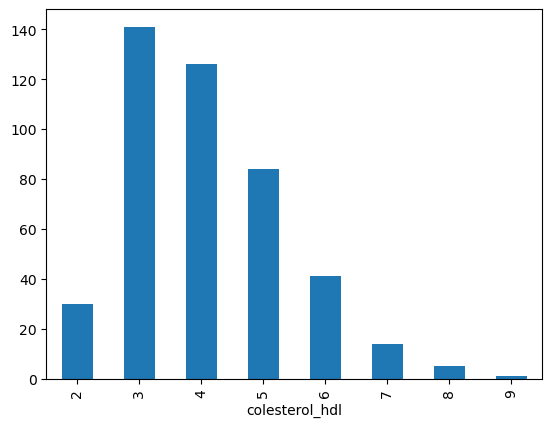

In [85]:
df['colesterol_hdl'].value_counts().sort_index().plot(kind='bar')

In [86]:
# o ideal pela quantidade de dados que a gente tem é agrupar ainda mais as colunas, ajuntando 2 com 3 e etc.

df['colesterol_hdl_cat'] = pd.cut(
    df['colesterol_hdl'],
    bins=[2, 4, 6, 10],
    labels=["2-3", "4-5", "6+"],
    right=False,
)
df["colesterol_hdl_cat"].value_counts()

colesterol_hdl_cat
4-5    210
2-3    171
6+      61
Name: count, dtype: int64

In [87]:
df = df.drop(columns=["colesterol_hdl"])

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 442 entries, 0 to 441
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   idade               442 non-null    int32   
 1   sexo                442 non-null    int32   
 2   imc                 442 non-null    float64 
 3   pressao_media       442 non-null    float64 
 4   colesterol_total    442 non-null    int32   
 5   ldl                 442 non-null    float64 
 6   hdl                 442 non-null    float64 
 7   triglicerides       442 non-null    float64 
 8   glicose             442 non-null    int32   
 9   target              442 non-null    int32   
 10  colesterol_hdl_cat  442 non-null    category
dtypes: category(1), float64(5), int32(5)
memory usage: 26.6 KB


In [88]:
df['sexo'] = df['sexo'].astype("category")

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 442 entries, 0 to 441
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   idade               442 non-null    int32   
 1   sexo                442 non-null    category
 2   imc                 442 non-null    float64 
 3   pressao_media       442 non-null    float64 
 4   colesterol_total    442 non-null    int32   
 5   ldl                 442 non-null    float64 
 6   hdl                 442 non-null    float64 
 7   triglicerides       442 non-null    float64 
 8   glicose             442 non-null    int32   
 9   target              442 non-null    int32   
 10  colesterol_hdl_cat  442 non-null    category
dtypes: category(2), float64(5), int32(4)
memory usage: 25.4 KB


In [89]:
df.to_parquet("../dados/diabete_categorizado.parquet")

In [90]:
colunas_power_transform = ["imc", "ldl", "hdl", "colesterol_total"]

coluna_target = ["target"]

coluna_ordinal_encoder = ["colesterol_hdl_cat"]

coluna_one_hot_encoder = ["sexo"]

coluna_standard_scaler = [
    coluna for coluna in df.columns if coluna not in colunas_power_transform + coluna_target + coluna_ordinal_encoder + coluna_one_hot_encoder
]

coluna_standard_scaler

['idade', 'pressao_media', 'triglicerides', 'glicose']

In [91]:
categorias_ordinal_encoder = [
    ["2-3", "4-5", "6+"],
]

## Pipeline


In [92]:
X = df.drop(columns='target')
y = df['target']

In [93]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

In [94]:
preprocessamento = ColumnTransformer([
    ("power_transform", PowerTransformer(method='box-cox'), colunas_power_transform),
    ("stander_scaler", StandardScaler(), coluna_standard_scaler),
    ("ordinal_encoder", OrdinalEncoder(categories=categorias_ordinal_encoder), coluna_ordinal_encoder),
    ("one_hot_encoder", OneHotEncoder(drop='if_binary'), coluna_one_hot_encoder)
])

pipeline = Pipeline([
    ("prepocessor", preprocessamento),
    ("reg", LinearRegression())
])

pipeline

Pipeline(steps=[('prepocessor',
                 ColumnTransformer(transformers=[('power_transform',
                                                  PowerTransformer(method='box-cox'),
                                                  ['imc', 'ldl', 'hdl',
                                                   'colesterol_total']),
                                                 ('stander_scaler',
                                                  StandardScaler(),
                                                  ['idade', 'pressao_media',
                                                   'triglicerides',
                                                   'glicose']),
                                                 ('ordinal_encoder',
                                                  OrdinalEncoder(categories=[['2-3',
                                                                              '4-5',
                                                                              '6+']]),
                                                  ['colesterol_hdl_cat']),
                                                 ('one_hot_encoder',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['sexo'])])),
                ('reg', LinearRegression())])

Se eu tivesse 3 colunas de ordinal seria assim 

```
coluna_ordinal_encoder=["faixa_filhos","faixa_quartos","faixa_dependentes"]

categorias_ordinal_encoder=[
    ["0-1","2-3","4+"],
    ["1-2","3-4","5+"],
    ["0","1-2","3+"]
]

("ordinal_encoder",OrdinalEncoder(categories=categorias_ordinal_encoder),coluna_ordinal_encoder)
```

In [95]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('prepocessor',
                 ColumnTransformer(transformers=[('power_transform',
                                                  PowerTransformer(method='box-cox'),
                                                  ['imc', 'ldl', 'hdl',
                                                   'colesterol_total']),
                                                 ('stander_scaler',
                                                  StandardScaler(),
                                                  ['idade', 'pressao_media',
                                                   'triglicerides',
                                                   'glicose']),
                                                 ('ordinal_encoder',
                                                  OrdinalEncoder(categories=[['2-3',
                                                                              '4-5',
                                                                              '6+']]),
                                                  ['colesterol_hdl_cat']),
                                                 ('one_hot_encoder',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['sexo'])])),
                ('reg', LinearRegression())])

In [96]:
pipeline.named_steps

{'prepocessor': ColumnTransformer(transformers=[('power_transform',
                                  PowerTransformer(method='box-cox'),
                                  ['imc', 'ldl', 'hdl', 'colesterol_total']),
                                 ('stander_scaler', StandardScaler(),
                                  ['idade', 'pressao_media', 'triglicerides',
                                   'glicose']),
                                 ('ordinal_encoder',
                                  OrdinalEncoder(categories=[['2-3', '4-5',
                                                              '6+']]),
                                  ['colesterol_hdl_cat']),
                                 ('one_hot_encoder',
                                  OneHotEncoder(drop='if_binary'), ['sexo'])]),
 'reg': LinearRegression()}

In [97]:
reg: LinearRegression = pipeline['reg']

reg.coef_

array([ 24.60290388,  16.78296511,  -0.13714407, -33.23818656,
         0.90944892,  16.86897214,  31.42595203,   3.20214427,
        13.19323789, -24.68911987])

In [98]:
reg.intercept_

155.40507824349743

In [99]:
pipeline['prepocessor'].feature_names_in_

array(['idade', 'sexo', 'imc', 'pressao_media', 'colesterol_total', 'ldl',
       'hdl', 'triglicerides', 'glicose', 'colesterol_hdl_cat'],
      dtype=object)

In [100]:
pipeline['prepocessor'].get_feature_names_out()

array(['power_transform__imc', 'power_transform__ldl',
       'power_transform__hdl', 'power_transform__colesterol_total',
       'stander_scaler__idade', 'stander_scaler__pressao_media',
       'stander_scaler__triglicerides', 'stander_scaler__glicose',
       'ordinal_encoder__colesterol_hdl_cat', 'one_hot_encoder__sexo_2'],
      dtype=object)

In [101]:
dataframe_coeficientes(reg.coef_, pipeline['prepocessor'].get_feature_names_out())


,coeficiente
power_transform__colesterol_total,-33.238187
one_hot_encoder__sexo_2,-24.689120
power_transform__hdl,-0.137144
stander_scaler__idade,0.909449
stander_scaler__glicose,3.202144
ordinal_encoder__colesterol_hdl_cat,13.193238
power_transform__ldl,16.782965
stander_scaler__pressao_media,16.868972
power_transform__imc,24.602904
stander_scaler__triglicerides,31.425952


In [102]:
y_pred = pipeline.predict(X_test)

In [103]:
mean_absolute_error(y_test, y_pred)

43.64265522498252

In [104]:
mean_squared_error(y_test, y_pred)

2957.289587119406

In [105]:
root_mean_squared_error(y_test, y_pred)

54.38096714034614

In [106]:
r2_score(y_test, y_pred)

0.44182618250838135

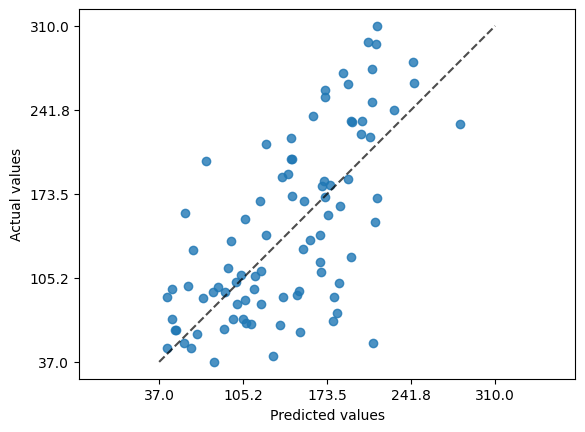

In [107]:
from sklearn.metrics import PredictionErrorDisplay

PredictionErrorDisplay.from_predictions(
    y_true=y_test,
    y_pred=y_pred,
    kind='actual_vs_predicted'
)